In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.inspection import permutation_importance
import joblib
import os

In [8]:
# Create directory for saving models and results
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [13]:
# Load the dataset with ground truth SpO2 values
df = pd.read_csv('rppg_features_dataset_with_spo2.csv')

# Remove rows with missing ground truth values
# df_clean = df.dropna(subset=['ground_truth_spo2'])
df_clean = df.dropna()

# Prepare features and target variable
# Exclude non-feature columns
non_feature_cols = ['filename', 'ground_truth_spo2']
feature_cols = [col for col in df_clean.columns if col not in non_feature_cols]

X = df_clean[feature_cols]
y = df_clean['ground_truth_spo2']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

# Save feature names for later use
feature_names = X.columns.tolist()

In [14]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Train_MSE': [train_mse],
        'Test_MSE': [test_mse],
        'Train_MAE': [train_mae],
        'Test_MAE': [test_mae],
        'Train_R2': [train_r2],
        'Test_R2': [test_r2]
    })
    
    # Save model
    joblib.dump(model, f'models/{model_name}.pkl')
    
    return metrics_df, y_pred_test

# Initialize dictionary to store models and their configurations
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1.0, 10.0]}
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {'alpha': [0.001, 0.01, 0.1, 1.0]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    },
    'MLP': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'alpha': [0.0001, 0.001, 0.01]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    }
}

In [15]:
# Initialize results dataframe
all_metrics = pd.DataFrame()
predictions = {}

# Run hyperparameter tuning and evaluate each model
for name, config in models.items():
    print(f"Training {name}...")
    
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Skip GridSearchCV for Linear Regression (no hyperparameters)
    if name == 'Linear Regression':
        best_model = config['model']
    else:
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Evaluate the best model
    metrics, y_pred = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    all_metrics = pd.concat([all_metrics, metrics], ignore_index=True)
    predictions[name] = y_pred

# Save all metrics
all_metrics.to_csv('results/model_comparison_metrics.csv', index=False)
print("Model evaluation complete. Results saved to 'results/model_comparison_metrics.csv'")


Training Linear Regression...
Training Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 1.0}
Training Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 0.01}
Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Training SVR...
Best parameters for SVR: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Training MLP...
Best parameters for MLP: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Model evaluation complete. Results saved to 'results/model_comparison_metrics.csv'


Visualizations saved to 'results' directory.


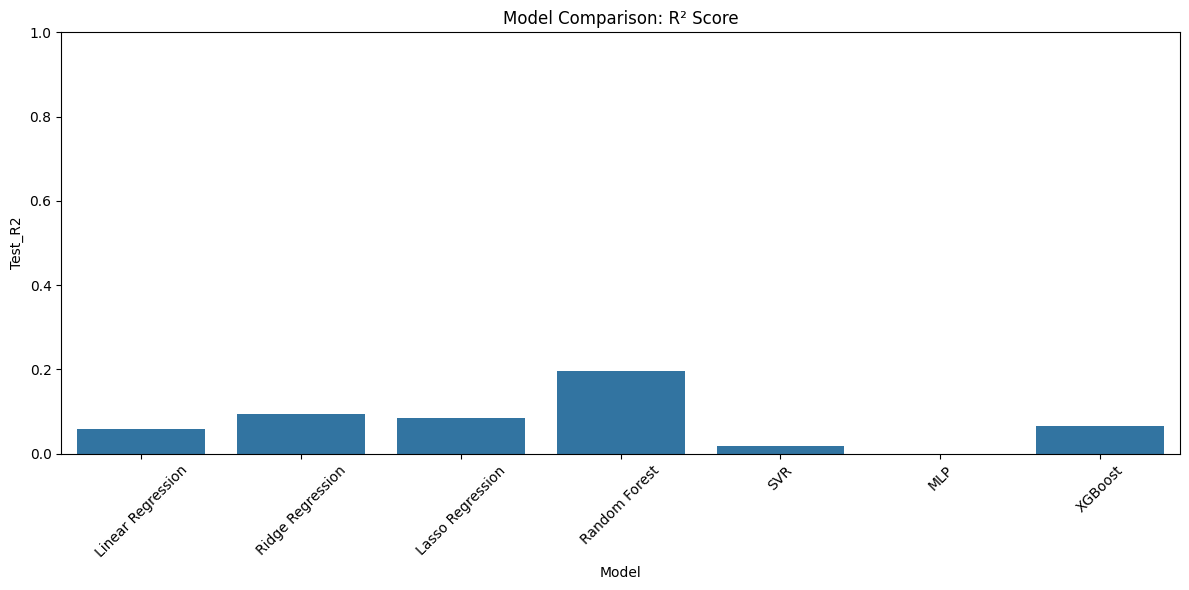

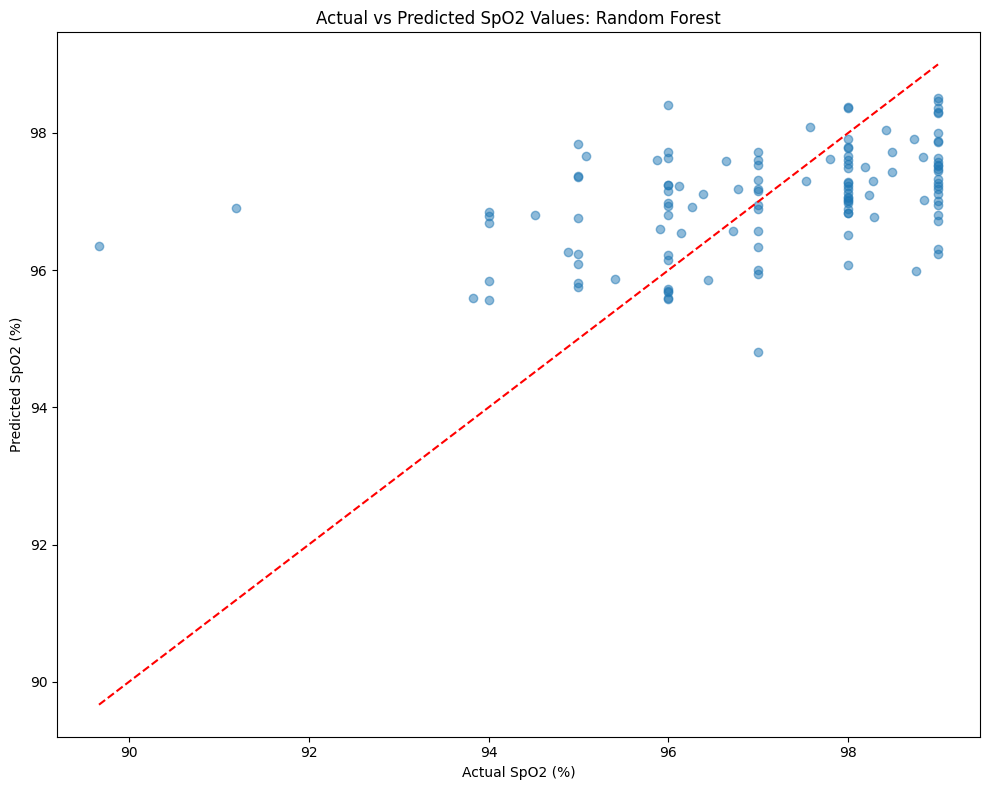

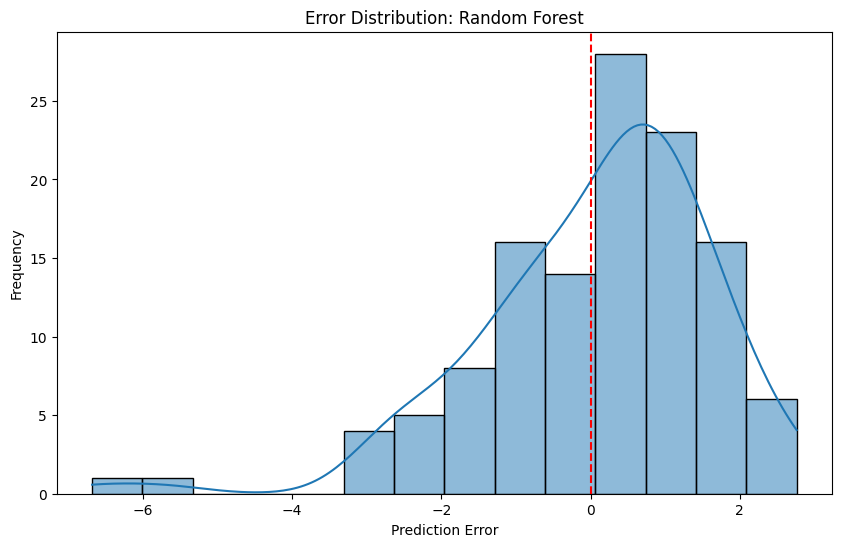

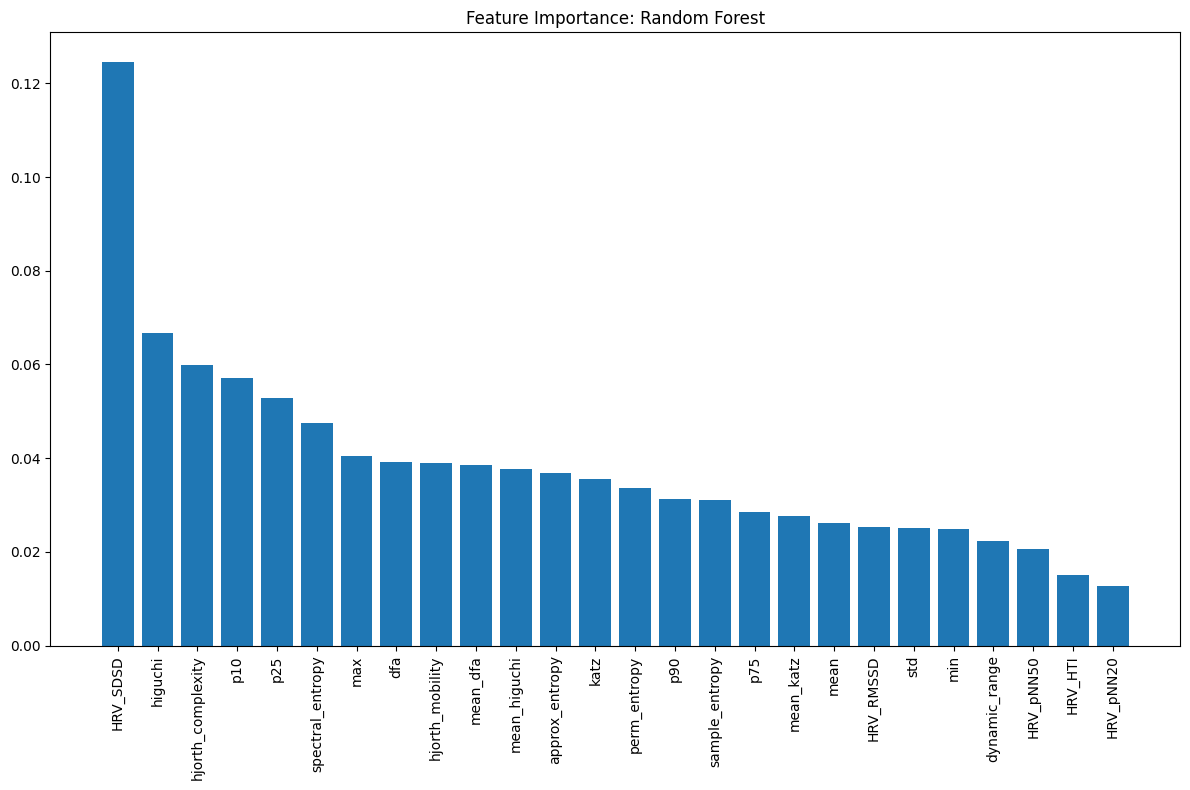

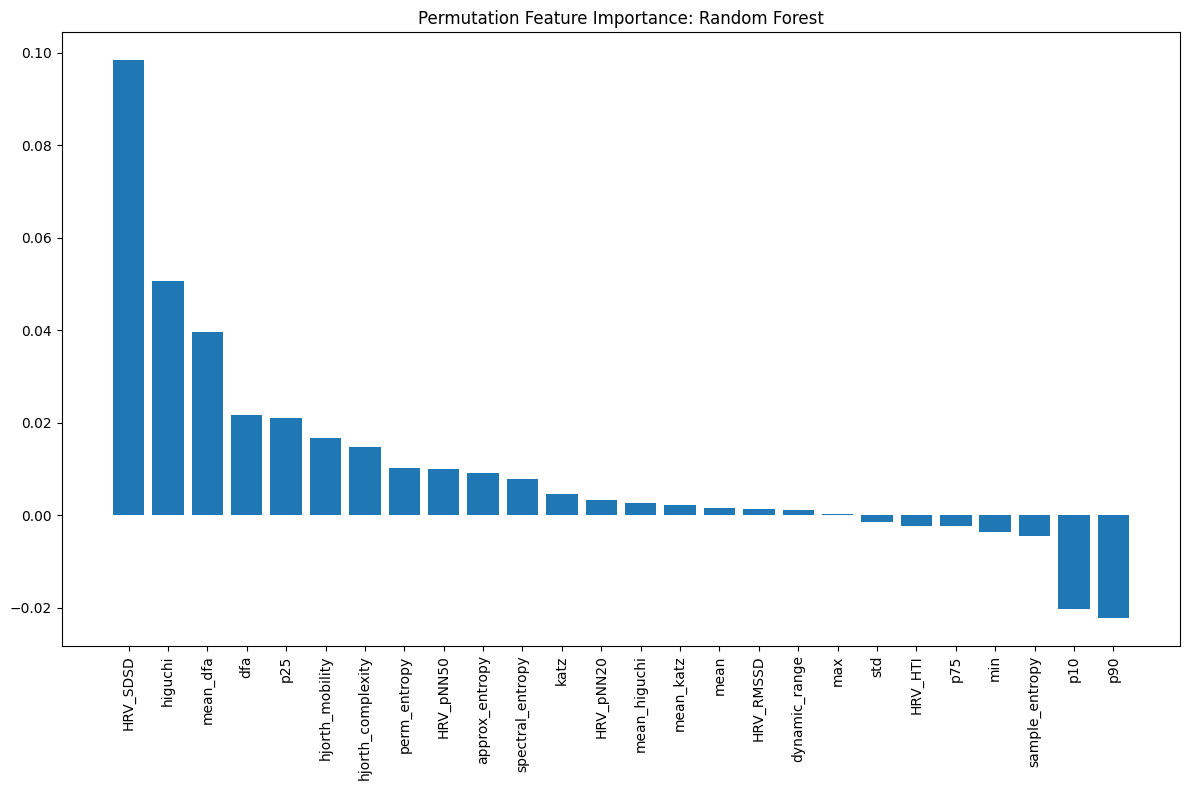

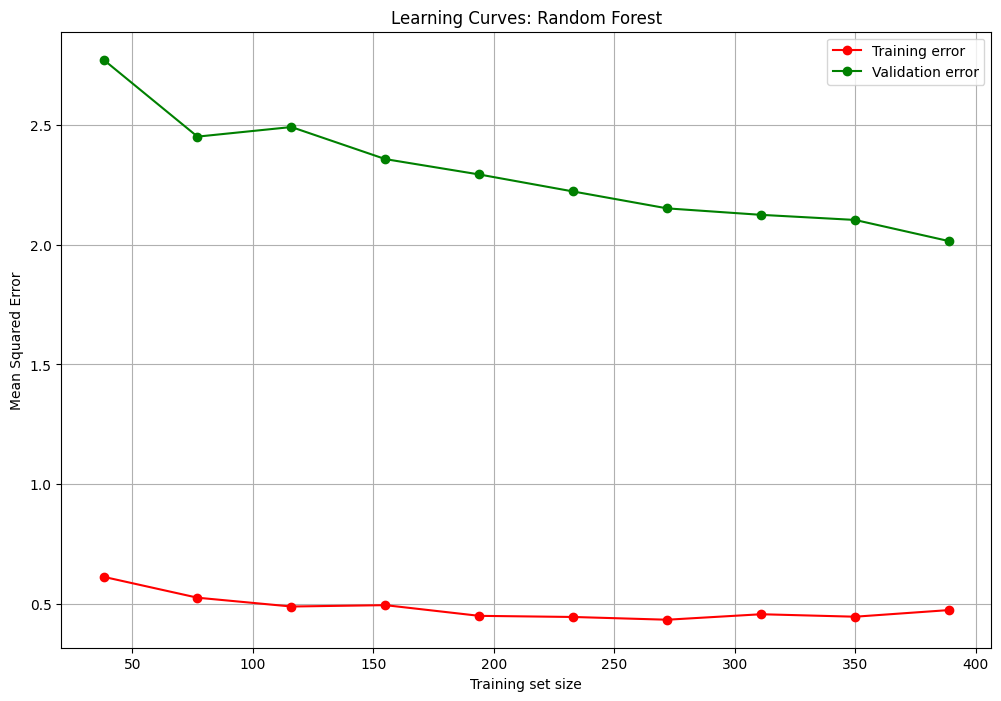

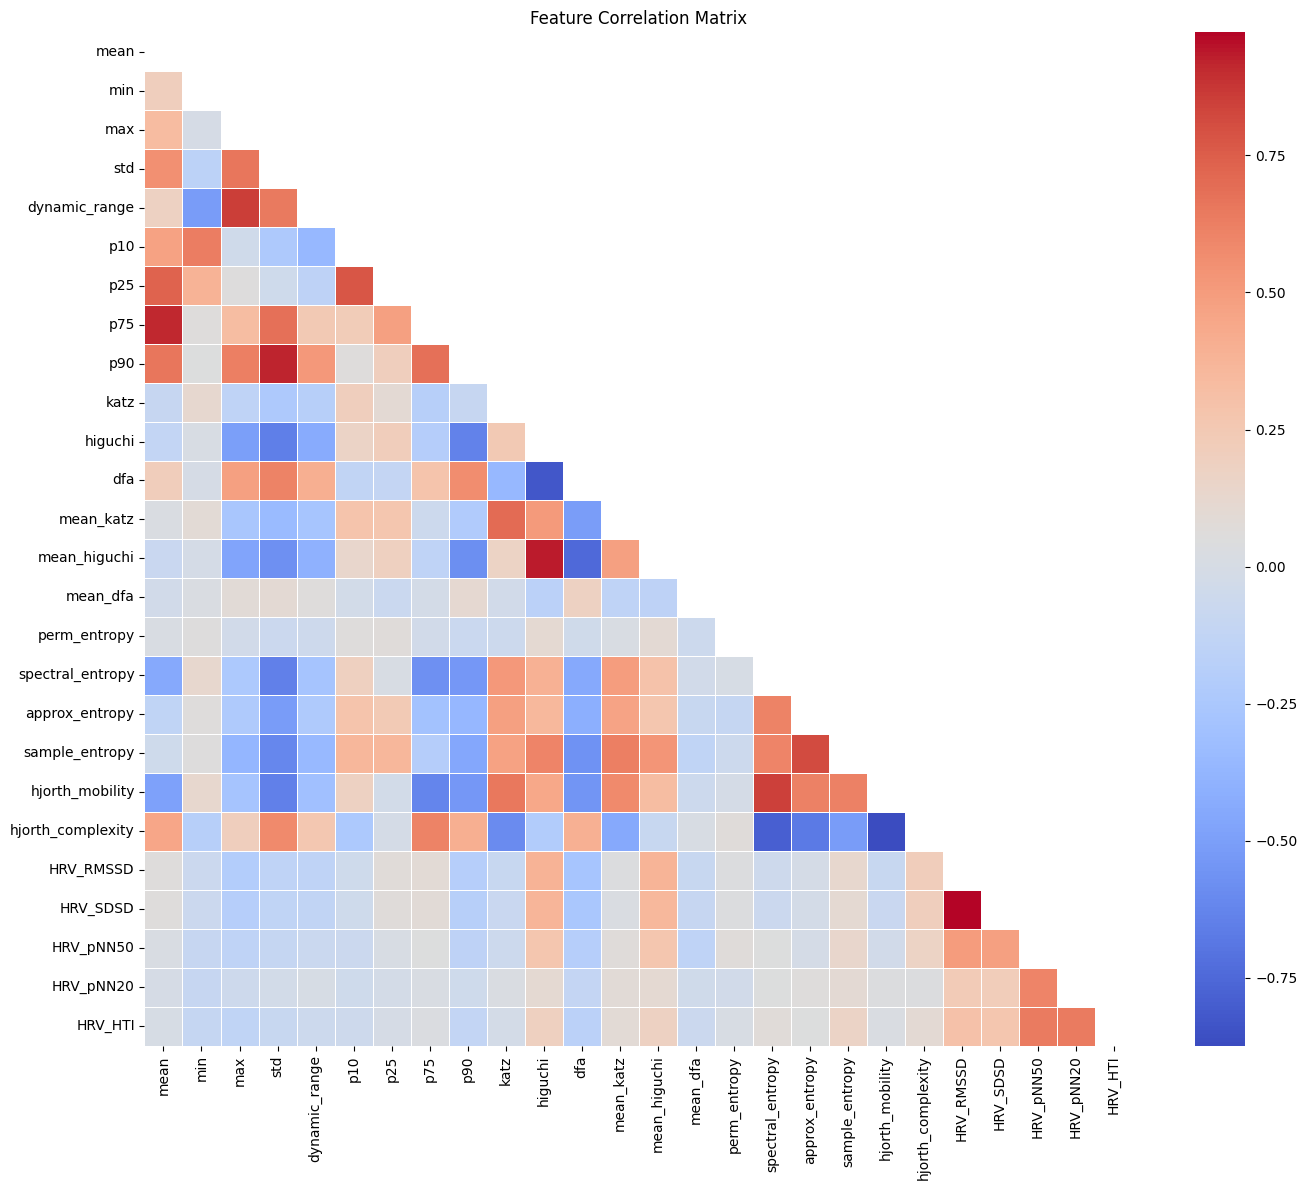

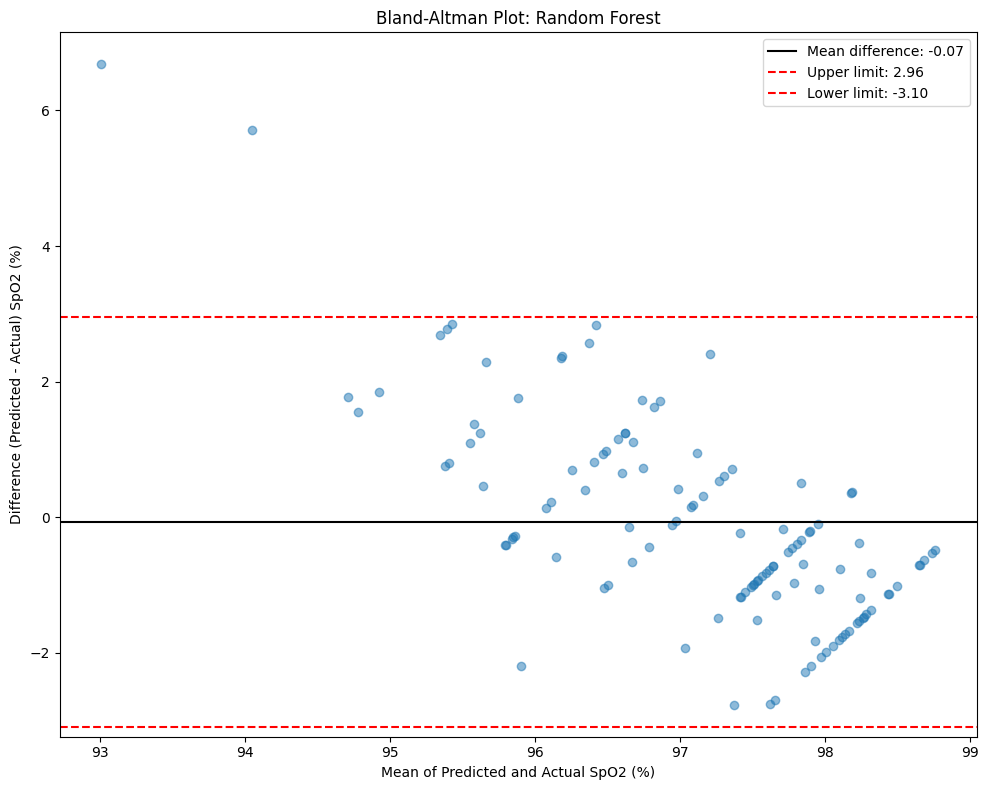

In [16]:
# 1. Model Performance Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Test_R2', data=all_metrics)
plt.title('Model Comparison: R² Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # R² typically ranges from 0 to 1
plt.tight_layout()
plt.savefig('results/model_r2_comparison.png')

# 2. Prediction vs Actual Plot for best model
best_model_name = all_metrics.loc[all_metrics['Test_R2'].idxmax(), 'Model']
plt.figure(figsize=(10, 8))
plt.scatter(y_test, predictions[best_model_name], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual SpO2 (%)')
plt.ylabel('Predicted SpO2 (%)')
plt.title(f'Actual vs Predicted SpO2 Values: {best_model_name}')
plt.tight_layout()
plt.savefig('results/best_model_predictions.png')

# 3. Error Distribution for best model
plt.figure(figsize=(10, 6))
errors = y_test - predictions[best_model_name]
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title(f'Error Distribution: {best_model_name}')
plt.axvline(x=0, color='r', linestyle='--')
plt.savefig('results/error_distribution.png')

# 4. Feature Importance Analysis (for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost']:
    best_model = joblib.load(f'models/{best_model_name}.pkl')
    
    # Direct feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance: {best_model_name}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('results/feature_importance.png')
    
    # Permutation importance (more reliable for some models)
    result = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    perm_importance = result.importances_mean
    perm_indices = np.argsort(perm_importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Permutation Feature Importance: {best_model_name}')
    plt.bar(range(X.shape[1]), perm_importance[perm_indices], align='center')
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in perm_indices], rotation=90)
    plt.tight_layout()
    plt.savefig('results/permutation_importance.png')

# 5. Learning Curves to detect overfitting/underfitting
plt.figure(figsize=(12, 8))
best_model = joblib.load(f'models/{best_model_name}.pkl')

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title(f'Learning Curves: {best_model_name}')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('results/learning_curves.png')

# 6. Correlation Matrix of Features
plt.figure(figsize=(14, 12))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('results/correlation_matrix.png')

print("Visualizations saved to 'results' directory.")

# 7. Bland-Altman Plot for Agreement Analysis
def bland_altman_plot(y_true, y_pred, model_name):
    difference = y_pred - y_true
    mean = (y_pred + y_true) / 2
    
    # Calculate mean difference and limits of agreement
    mean_diff = np.mean(difference)
    std_diff = np.std(difference)
    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff
    
    # Create plot
    plt.figure(figsize=(10, 8))
    plt.scatter(mean, difference, alpha=0.5)
    plt.axhline(mean_diff, color='k', linestyle='-', label=f'Mean difference: {mean_diff:.2f}')
    plt.axhline(upper_limit, color='r', linestyle='--', label=f'Upper limit: {upper_limit:.2f}')
    plt.axhline(lower_limit, color='r', linestyle='--', label=f'Lower limit: {lower_limit:.2f}')
    plt.xlabel('Mean of Predicted and Actual SpO2 (%)')
    plt.ylabel('Difference (Predicted - Actual) SpO2 (%)')
    plt.title(f'Bland-Altman Plot: {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/bland_altman_{model_name}.png')

# Create Bland-Altman plot for the best model
bland_altman_plot(y_test, predictions[best_model_name], best_model_name)
